# LSTM scaling
After successfully optimizing a LSTM based neural network to predict wildfire risk in one California geopsatial bin, the next step is scale the model to make predictions for all 410 geospatial bins. A parallel LSTM architecture will be employed. Each of the 410 geospatial bins in California will get it's own input layer and LSTM layer, these will then be concatenated via a merge layer. The model output will be a 410 member vector where each element represents the prediction for one of the original geospatial bins.

### Goal: 
Scale LSTM neural network to make predictions for all 410 geospatial bins in California. Save trained model weights and optimized hyperparameters for deployment.

### Plan:
1. Prep data from one geospatial bin for input into LSTM
2. Build parallel LSTM model
3. Using hyperparameters from the single LSTM model as a starting point, tune and evaluate the parallel LSTM model.
4. Save trained model weights and hyperparameters for model deployment

# Notebook setup

In [1]:
import os
import sys
import logging
import tensorflow as tf

# Note: tf 2.1.0 give warning about model weight format when
# using class weights. This is the only way to silence without
# updating
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import pandas as pd
import tensorflow as tf
import sklearn as sk
from pickle import dump

from tensorflow import keras
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.client import device_lib

# Note: sklearn forces depreciation warnings
# This is the only way to silence them without updating
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

import helper_functions.plotting_functions as plotting_functions
import helper_functions.data_functions as data_functions
import helper_functions.config as config

print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sk.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.1.0
Keras 2.2.4-tf
SciKit Learn 0.22.1

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


In [2]:
# load configuration variables
data_file = config.training_data_file

features = config.features
features_to_scale = config.features_to_scale
months = config.months

left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = config.fig_rows
fig_cols = config.fig_cols
plot_height = config.plot_height
plot_width = config.plot_width
plot_locations = config.plot_locations

metrics = config.metrics

# 1. Data preparation

In [3]:
# read data and grab features of intrest
raw_data = pd.read_parquet(data_file)
data = raw_data[features]

In [4]:
num_fires = data['ignition'].sum()
total_observations = len(data)

### One hot encode month

In [5]:
onehot_encoder = OneHotEncoder(sparse=False)

# get months from each row of data, reshape from wide to long
month = np.array(pd.DatetimeIndex(data['date']).month).reshape(-1, 1)

# onehot encode
onehot_month = onehot_encoder.fit_transform(month)

# convert to pandas dataframe with named columns
onehot_month_df = pd.DataFrame(onehot_month, columns=months)

# set type to int
onehot_month_df = onehot_month_df.astype('int32')

# reset indexes
onehot_month_df.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

# join months back to data along rows
data = pd.concat([data, onehot_month_df], axis=1)

### Feature scaling and normalization
Next, we will use the Box-Cox transform to enforce a normal distribution on our data, then use a min-max scaler to put it the range (-1, 1) so that it matches the effective range of the tanh activation function used by the LSTM layer.

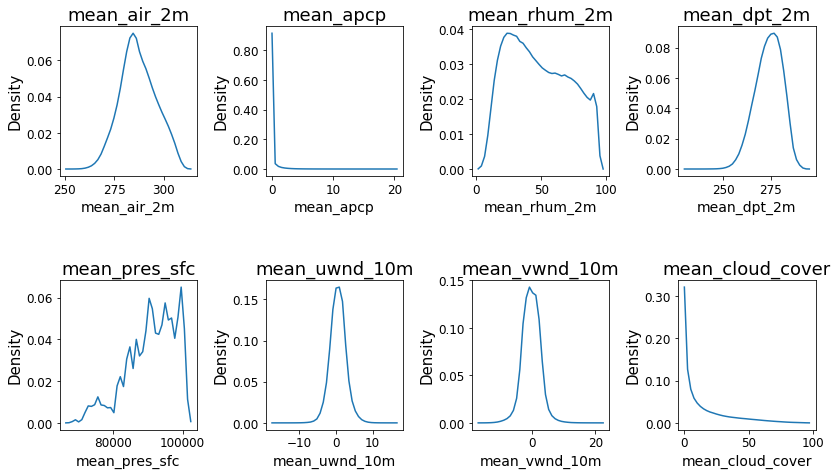

In [6]:
# plot weather data distributions before scaling
xlabels = features_to_scale
ylabels = ['Density'] * len(features_to_scale)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features_to_scale)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        data, 
        features_to_scale[i], 
        features_to_scale[i], 
        features_to_scale[i], 
        ylabels[i]
    )

As you can see, some of the weather variables are somewhat normally distributed and some are far from it. The ranges also vary widely. Lets do what we can to fix that before the training phase.

In [7]:
# use box-cox to enforce normal distributions on data
qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
normalized_data = pd.DataFrame(qt.fit_transform(data[features_to_scale]), columns=features_to_scale)
data[features_to_scale] = normalized_data
dump(qt, open('./data_transformations/quantile_transformer', 'wb'))

# min-max scale data into (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = scaler.fit_transform(data[features_to_scale])
data[features_to_scale] = scaled_features
dump(scaler, open('./data_transformations/min_max_scaler', 'wb'))

# reset dtype
data[features_to_scale] = data[features_to_scale].astype('float32')

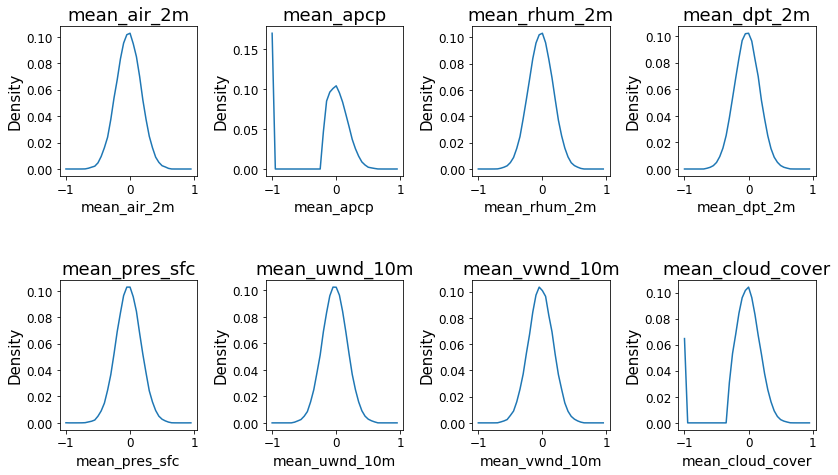

In [8]:
# plot weather data distributions after scaling
xlabels = features_to_scale
ylabels = ['Density'] * len(features_to_scale)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features_to_scale)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        data, 
        features_to_scale[i], 
        features_to_scale[i], 
        features_to_scale[i], 
        ylabels[i]
    )
    
plt.show()

Except for vegetation coverage and categorical rain, the distributions now look much better.

### Split data into training, validation and testing sets
Note: since temporal order matters here, we cannot simply randomly sample the data - we need to preserve the order. One possible improvement could be to break the data into many smaller ordered chunks and then sample those randomly...

In [9]:
# make sure data is sorted by date, then drop date column
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data.sort_index()
data.reset_index(inplace=True)#, drop=True)

In [10]:
# Split data up into training, testing and validation sets
testing_data = data.tail(int(len(data) * 0.25))
leftover_data = data.head(int(len(data) * 0.75))
validation_data = data.tail(int(len(leftover_data) * 0.5))
training_data = data.head(int(len(leftover_data) * 0.5))

Let's compare the distributions of each weather variable across the train, validation and test sets just to be sure that our samples are matched to a first approximation.

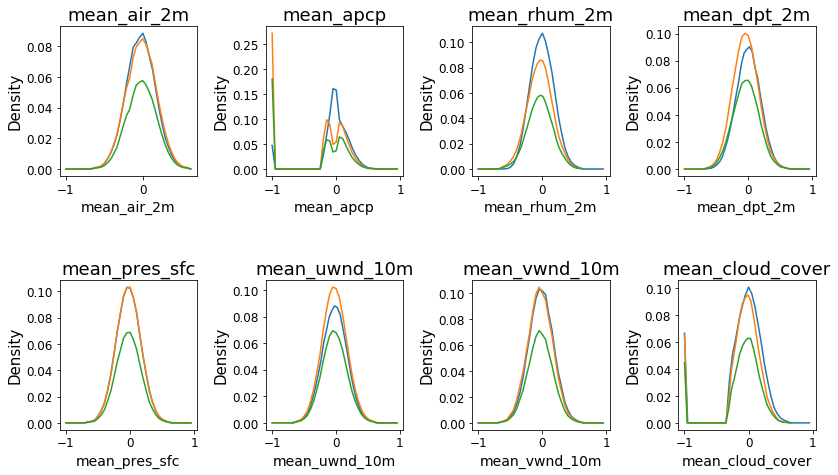

In [11]:
# plot split data distributions
xlabels = features_to_scale
ylabels = ['Density'] * len(features_to_scale)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features_to_scale)):
    ax[plot_locations[i]] = plotting_functions.three_sample_density_plot(
        ax,
        plot_locations[i], 
        training_data, 
        validation_data, 
        testing_data, 
        features_to_scale[i], 
        features_to_scale[i], 
        features_to_scale[i], 
        ylabels[i]
    )
    
plt.show()

### Format data for parallel LSTM
This part is a bit tricky - we need to form our data into samples, each sample containing 5 days of past history. Then we need a sequence of samples which spans the data set for each geospatial bin. Therefore, our input data will be a 410 member list of numpy arrays. The labels will be formated such that the first dimension is time and each time step contains a 410 member vector, one element for each of the 410 bins we are making predictions for.

In [12]:
num_fires = data['ignition'].sum()
total_observations = len(data)

print("Fires observed: {}".format(num_fires))
print("Total observations: {}".format(total_observations))
print()
print("Training data: {} observations".format(len(training_data)))
print("Validation data: {} observations".format(len(validation_data)))
print("Testing data: {} observations".format(len(testing_data)))

Fires observed: 231024.0
Total observations: 3594060

Training data: 1347772 observations
Validation data: 1347772 observations
Testing data: 898515 observations


In [13]:
# Split data into 410 member lists, one element for each geospatial bin (and network input)
# each element of the list contains samples with a duration of past_history

past_history = 5
future_target = 1
step = 1

x_training, y_training = data_functions.format_features_labels_for_LSTM(
    training_data,        # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_validation, y_validation = data_functions.format_features_labels_for_LSTM(
    validation_data,      # incomming_data
    past_history,         # size of past history time chun
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_testing, y_testing = data_functions.format_features_labels_for_LSTM(
    testing_data,         # incomming_data
    past_history,         # size of past history time chun
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

In [14]:
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print()
print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
print()
print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))

x_training is <class 'list'>, length: 410, member shape: (3281, 5, 22).
y_training is <class 'list'>, length: 410, member shape: (3281,).

x_validation is <class 'list'>, length: 410, member shape: (3281, 5, 22).
y_validation is <class 'list'>, length: 410, member shape: (3281,).

x_testing is <class 'list'>, length: 410, member shape: (2186, 5, 22).
y_testing is <class 'list'>, length: 410, member shape: (2186,).


In [15]:
x_training, y_training = data_functions.trim_and_reshape_for_LSTM(x_training, y_training)
x_validation, y_validation = data_functions.trim_and_reshape_for_LSTM(x_validation, y_validation)
x_testing, y_testing = data_functions.trim_and_reshape_for_LSTM(x_testing, y_testing)

In [16]:
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print()
print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
print()
print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))

x_training is <class 'list'>, length: 410, member shape: (3281, 5, 22).
y_training is <class 'list'>, length: 3281, member shape: (410,).

x_validation is <class 'list'>, length: 410, member shape: (3281, 5, 22).
y_validation is <class 'list'>, length: 3281, member shape: (410,).

x_testing is <class 'list'>, length: 410, member shape: (2185, 5, 22).
y_testing is <class 'list'>, length: 2185, member shape: (410,).


In [17]:
# Trim each sample again to be a multiple of the batch size so we
# can do minibatch gradient descent - Note: this is required for statefull LSTMs

BATCH_SIZE = 100

for i in range(len(x_training)):
    start_index = (x_training[i].shape[0] - (x_training[i].shape[0] % BATCH_SIZE))
    end_index = x_training[i].shape[0]

    x_training[i] = np.delete(x_training[i], range(start_index, end_index), axis=0)

y_training = np.delete(y_training, range(start_index, end_index), axis=0)

for i in range(len(x_validation)):
    start_index = (x_validation[i].shape[0] - (x_validation[i].shape[0] % BATCH_SIZE))
    end_index = x_validation[i].shape[0]

    x_validation[i] = np.delete(x_validation[i], range(start_index, end_index), axis=0)

y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

for i in range(len(x_testing)):
    start_index = (x_testing[i].shape[0] - (x_testing[i].shape[0] % BATCH_SIZE))
    end_index = x_testing[i].shape[0]

    x_testing[i] = np.delete(x_testing[i], range(start_index, end_index), axis=0)

y_testing = np.delete(y_testing, range(start_index, end_index), axis=0)

In [18]:
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print()
print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
print()
print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))

x_training is <class 'list'>, length: 410, member shape: (3200, 5, 22).
y_training is <class 'numpy.ndarray'>, length: 3200, member shape: (410,).

x_validation is <class 'list'>, length: 410, member shape: (3200, 5, 22).
y_validation is <class 'numpy.ndarray'>, length: 3200, member shape: (410,).

x_testing is <class 'list'>, length: 410, member shape: (2100, 5, 22).
y_testing is <class 'numpy.ndarray'>, length: 2100, member shape: (410,).


# 2. Build parallel LSTM model
The general model architecture is as follows - 410 input layers, one for each geospatial bin. Each input feeds into it's own LSTM layer. The LSTM layers are then concatenated and make there way through a number of fully connected layers and finally to a 410 member sigmoid activated output.

The loss function used is weighted binary cross-entropy. As this is a multilabel classification, not a multiclass classification softmax and categorical cross-entropy are not good choices because we can have more than one positive output amount the 410 for each time step.

In [19]:
# hyperparameters (adapted from single LSTM Cassandra model)
learning_rate = 0.001
parallel_lstm_units = 1
hidden_units = 410 * 5
hidden_l1_lambda = 0.1
variational_dropout = 0.4
class_0_weight = 6.3720941191248395
class_1_weight = 94.18261239534365

# class_0_weight = (1 / (total_observations - num_fires))*(total_observations)/2.0 
# class_1_weight = ((1 / num_fires)*(total_observations)/2.0)#*0.8

raw_output_bias = np.log([num_fires/(total_observations - num_fires)])[0]
output_bias = tf.keras.initializers.Constant(raw_output_bias)

print(f'Inital output bias: {raw_output_bias}')
print(f'Class 0 weight: {class_0_weight}')
print(f'Class 1 weight: {class_1_weight}')


metrics = [
    tf.keras.metrics.TruePositives(thresholds = 0.1, name = "true_positives"),
    tf.keras.metrics.FalsePositives(thresholds = 0.1, name = "false_positives"),
    tf.keras.metrics.TrueNegatives(thresholds = 0.1, name = "true_negatives"),
    tf.keras.metrics.FalseNegatives(thresholds = 0.1, name = "false_negatives"),
    tf.keras.metrics.Precision(thresholds = 0.1, name = "precision"), # TP / (TP + FP)
    tf.keras.metrics.Recall(thresholds = 0.1, name = "recall"),        # TP / (TP + FN)
]

Inital output bias: -2.6780778151820326
Class 0 weight: 6.3720941191248395
Class 1 weight: 94.18261239534365


In [22]:
inputs = []
LSTMs = []

# make list of inputs, one for each geospatial bin
for i in range(len(x_training)):
    inputs.append(
        keras.Input(
            batch_shape=(
                BATCH_SIZE,
                x_training[0].shape[1],
                x_training[0].shape[2]
            )
        )
    )
    
# make list of LSTM layers, one for each geospatial bin
for i in range(len(x_training)):
    LSTMs.append(keras.layers.LSTM(
        parallel_lstm_units,
        dropout = variational_dropout,
        stateful = True
    )(inputs[i]))
    
# merge LSTM layers with concat layer
merged = keras.layers.concatenate(LSTMs)

# sequence of fully connected layers
hidden1 = keras.layers.Dense(
    hidden_units,
    kernel_regularizer=keras.regularizers.l1(hidden_l1_lambda),
    bias_initializer=tf.keras.initializers.he_normal(),
    activation = 'relu'
)(merged)

hidden2 = keras.layers.Dense(
    (hidden_units // 2),
    kernel_regularizer=keras.regularizers.l1(hidden_l1_lambda),
    bias_initializer=tf.keras.initializers.he_normal(),
    activation = 'relu'
)(hidden1)

hidden3 = keras.layers.Dense(
    (hidden_units // 3),
    kernel_regularizer=keras.regularizers.l1(hidden_l1_lambda),
    bias_initializer=tf.keras.initializers.he_normal(),
    activation = 'relu'
)(hidden2)

# output layer
output = keras.layers.Dense(
    410,
    activation = 'sigmoid',
    bias_initializer = output_bias
)(hidden2)

# compile model
model = keras.Model(inputs=inputs, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr = learning_rate),
    loss = data_functions.weighted_bce(class_0_weight, class_1_weight),
    metrics = metrics
)

# 2. Train and evaluate parallel LSTM model
The general model architecture is as follows - 410 input layers, one for each geospatial bin. Each input feeds into it's own LSTM layer. The LSTM layers are then concatenated and make there way through a number of fully connected layers and finally to a 410 member sigmoid activated output.

The loss function used is weighted binary cross-entropy. As this is a multilabel classification, not a multiclass classification softmax and categorical cross-entropy are not good choices because we can have more than one positive output amount the 410 for each time step.

In [ ]:
STEPS_PER_EPOCH = (x_training[0].shape[0] * 0.99) // BATCH_SIZE
VALIDATION_STEPS = (x_validation[0].shape[0] * 0.99) // BATCH_SIZE

# Use early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True
)

history = model.fit(
    x_training, 
    y_training,
    batch_size = BATCH_SIZE, 
    epochs = 40,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_steps = VALIDATION_STEPS,
    validation_data = (x_validation, y_validation),
    workers = 8
)

Train on 3200 samples, validate on 3200 samples
Epoch 1/40


In [ ]:
metrics =  ['loss', 'recall', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives']
filename = '../project_info/figures/parallel_LSTM_learning_curves.png'
print(f"Total observations: {len(training_data)}")
plot_metrics(history, metrics, filename)

In [ ]:
training_predictions = model.predict(x_training)
training_ignition_risk_predictions = training_predictions.flatten()
training_true_fires = y_training.flatten()

testing_predictions = model.predict(x_testing)
testing_ignition_risk_predictions = testing_predictions.flatten()
testing_true_fires = y_testing.flatten()

In [ ]:
sns.kdeplot(training_ignition_risk_predictions, cumulative=False, bw=0.01)
plt.xlim(-0.1, 1)
plt.show()

In [ ]:
training_results = model.evaluate(
    x_training,
    y_training 
)

testing_results = model.evaluate(
    x_testing,
    y_testing 
)

In [ ]:
training_results

In [ ]:
for name, value in zip(model.metrics_names, training_results):
    print(name, ': ', value)
    
plot_cm(training_true_fires, training_ignition_risk_predictions)

# 4. Save trained weights for deployment

In [ ]:
# save trained weights
model.save_weights('./trained_model_weights/parallel_LSTM_weights.tf')

Mock up some data to match what the live prediction data will look like to ensure the model works as expected after round tripping the weights.

In [ ]:
past_history = 5
future_target = 1
step = 1
BATCH_SIZE = 1

x_training, y_training = format_features_labels_for_LSTM(
    training_data,        # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_training, y_training = trim_and_reshape_for_LSTM(x_training, y_training)

for i in range(len(x_training)):
    start_index = (x_training[i].shape[0] - (x_training[i].shape[0] % BATCH_SIZE))
    end_index = x_training[i].shape[0]

    x_training[i] = np.delete(x_training[i], range(start_index, end_index), axis=0)

In [ ]:
mock_data = []

for spatial_bin in x_training:
    bin_slice = spatial_bin[0:7,:,]
    mock_data.append(bin_slice)
    
mock_labels = y_training[0:7]
    
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print("mock_data is {}, length: {}, member shape: {}.".format(type(mock_data), len(mock_data), mock_data[0].shape))
print("mock_labels are {}, length: {}, member shape: {}.".format(type(mock_labels), len(mock_labels), mock_labels[0].shape))

In [ ]:
inputs = []
LSTMs = []

for i in range(len(mock_data)):
    inputs.append(
        keras.Input(
            batch_shape=(
                BATCH_SIZE,
                mock_data[0].shape[1],
                mock_data[0].shape[2]
            )
        )
    )
    
for i in range(len(mock_data)):
    LSTMs.append(keras.layers.LSTM(
        lstm_units,
        dropout = variational_dropout,
        stateful = True
    )(inputs[i]))
    
merged = keras.layers.concatenate(LSTMs)

hidden1 = keras.layers.Dense(
    hidden_units,
    kernel_regularizer=keras.regularizers.l1(hidden_l1_lambda),
    bias_initializer=tf.keras.initializers.he_normal(),
    activation = 'relu'
)(merged)

hidden2 = keras.layers.Dense(
    hidden_units,
    kernel_regularizer=keras.regularizers.l1(hidden_l1_lambda),
    bias_initializer=tf.keras.initializers.he_normal(),
    activation = 'relu'
)(hidden1)

output = keras.layers.Dense(
    410,
    activation = 'sigmoid',
    bias_initializer = output_bias
)(hidden2)

production_model = keras.Model(inputs=inputs, outputs=output)

production_model.load_weights('./trained_model_weights/parallel_LSTM_weights.tf')
production_model.summary()

In [ ]:
mock_predictions = production_model.predict(mock_data)
flat_mock_predictions = mock_predictions.flatten()

In [ ]:
sns.kdeplot(flat_mock_predictions, cumulative=False, bw=0.01)
plt.xlim(-0.1, 1)
plt.show()